<a href="https://colab.research.google.com/github/TomasGandolfoR/Properati_house_prices/blob/main/DS_Proyecto_02_Gandolfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de ciencia de datos
### Caso de estudio: Precio de bienes inmueble en la Ciudad de Buenos Aires
#### *Tomás Gandolfo*
#### *Datos de Properati*

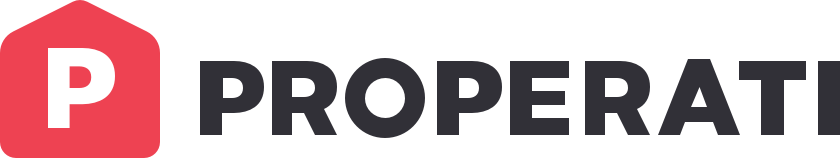

In [ ]:
from IPython import display 
display.Image("https://d3oky698b3gnfy.cloudfront.net/assets/img/isologo-properati.png",width=500)

## comprensión comercial
Según la página oficial de la empresa:
>La **misión** de Properati es empoderar a nuestros usuarios para que tengan el mejor camino a su próxima casa, mediante herramientas tecnológicas y datos relevantes. En paralelo, buscamos ayudar a los vendedores a que sean más eficientes y brinden el mejor servicio posible a los potenciales compradores.

>**Visión**: Ser la plataforma de inmuebles más enfocada en el usuario del mundo, sin importar dónde se encuentre. Tenemos un horizonte global, pero también la versatilidad necesaria para satisfacer las necesidades locales.

Adicionalmente:
>*Quienes busquen un nuevo hogar o quieran invertir* en propiedades encontrarán en Properati, además de las ofertas disponibles, valiosa información para tomar las mejores decisiones: promedios de precios, características de los barrios, comparaciones, etc.
>Properati también ofrece una propuesta novedosa para las *inmobiliarias o agentes* que quieran vender una propiedad, ya que el modelo de negocios se basa en entregar contactos de calidad.

Vemos que Properati brinda servicio tanto a compradores como vendedores. Entre estos servicios está el proporcionar información valiosa y de calidad para facilitar una correcta toma de decisiones, incluyendo los precios. Por lo que comprender cuáles son los las variables que más influyen en éstos y a su vez poder estimar cuál sería el precio más probable o acorde para una determinada propiedad, es sin dudas valioso para los fines del negocio.

**El presente proyecto se propone los siguientes objetivos:**
* Determinar cuáles son las variables que determinan los precios.
* Desarrollar los modelos predictortes de los precios.

El **alcance del proyecto** comprende los bienes inmueble del tipo PH, casas y departamentos en la Ciudad Autónoma de Buenos Aires.

Los datos fueron obtenidos por la página oficial de Properati, pre-filtrados por Acámica.

## Importación de librerías base

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from scipy.interpolate import griddata

import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1AjaUAYMrzpBHHr31aqvNFnhzCQOgrPtH'}) 
downloaded.GetContentFile('DS_Proyecto_01_Datos_Properati.csv')  
properati_df = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')# Dataset is now stored in a Pandas Dataframe

## Análisis exploratorio de los datos (EDA)

## Transfrmación de datos

In [ ]:
# Cargo el dataframe, filtro por los requisitos del estudio, lo limpio de NaN values y elimino valores inconsistentes.
#properati_df = pd.read_csv("/content/sample_data/DS_Proyecto_01_Datos_Properati.csv", quoting=csv.QUOTE_MINIMAL, error_bad_lines=False, engine='python')
properati_df = properati_df[(properati_df["l2"] == "Capital Federal") 
                            & ((properati_df["property_type"] == "Departamento") | (properati_df["property_type"] == "Casa") | (properati_df["property_type"] == "PH"))].copy()

In [ ]:
print(properati_df.info())
properati_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91485 entries, 0 to 146558
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_date       91485 non-null  object 
 1   end_date         91485 non-null  object 
 2   created_on       91485 non-null  object 
 3   lat              86951 non-null  float64
 4   lon              86937 non-null  float64
 5   l1               91485 non-null  object 
 6   l2               91485 non-null  object 
 7   l3               91485 non-null  object 
 8   rooms            91485 non-null  float64
 9   bedrooms         91485 non-null  float64
 10  bathrooms        89314 non-null  float64
 11  surface_total    82568 non-null  float64
 12  surface_covered  82250 non-null  float64
 13  price            91485 non-null  float64
 14  currency         91485 non-null  object 
 15  title            91485 non-null  object 
 16  description      91485 non-null  object 
 17  property_ty

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,86951.000000,86937.000000,91485.000000,91485.000000,89314.000000,82568.000000,82250.000000,9.148500e+04
mean,-34.599081,-58.436002,2.964278,1.960278,1.560147,112.626369,94.966310,2.595003e+05
std,0.023957,0.036297,1.314704,1.072946,0.860309,980.713664,778.515243,3.222654e+05
min,-34.696419,-58.530468,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,-34.613757,-58.459605,2.000000,1.000000,1.000000,49.000000,44.000000,1.200000e+05
50%,-34.599446,-58.433789,3.000000,2.000000,1.000000,71.000000,63.000000,1.750000e+05
75%,-34.584148,-58.410143,4.000000,3.000000,2.000000,111.000000,96.000000,2.790000e+05
max,-34.535818,-58.353930,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


Filtro inconsistencias de tamaño de la superficie

In [ ]:
properati_df = properati_df[properati_df.surface_total > properati_df.surface_covered]

Reviso la cantidad de filas con valores nulos 

In [ ]:
properati_df.isnull().any(axis=1).sum()

3427

Inspecciono qué porcentaje representan del total las filas con valores faltantes 

In [ ]:
print("Faltantes sobre el total: " + str(round((properati_df.isnull().any(axis=1).sum()/properati_df.shape[0])*100, 2)) + "%")
print('Tamaño total bruto:', properati_df.shape[0], 'filas')
print('Tamaño total neto sin NaN:', properati_df.shape[0]-properati_df.isnull().any(axis=1).sum(), 'filas')

Faltantes sobre el total: 6.05%
Tamaño total bruto: 56658 filas
Tamaño total neto sin NaN: 53231 filas


Como los features latitud y longitud pueden agregar información al crear clústers con ellos, serán de utilidad para el modelo y opto por conservar las variables y eliminar las filas con valores nulos en estas columnas.

En el caso de bathrooms, también serán eliminados ya que representan un bajo porcentraje del conjunto de datos y a su vez una vivienda sin baños presenta inconsistencias cuya causa es difícil de comprobar (puede deberse a falta de información o error de clasificación del tipo de inmueble).

In [ ]:
properati_df = properati_df.dropna()

### Detección y eliminación de outliers
Detectar los outliers es necesario ya que éstos pueden distorsionar el ajuste de los modelos, perjudicando la eficacia de los mismos, principalmente de la variable objetivo. Su eliminación o asignación de valores más típicos depende del análisis, en este caso los eliminimaremos dada la gran cantidad de datos disponible.

In [ ]:
def outliers_boxplot (work_df):
    fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(20,3))
    sns.boxplot(work_df.lat, palette = 'pastel', ax = axs[0][0])
    sns.boxplot(work_df.lon, palette = 'pastel', ax = axs[0][1])
    sns.boxplot(work_df.rooms, palette = 'pastel', ax = axs[0][2])
    sns.boxplot(work_df.bedrooms, palette = 'pastel', ax = axs[0][3])
    sns.boxplot(work_df.bathrooms, palette = 'pastel', ax = axs[1][0])
    sns.boxplot(work_df.surface_total, palette = 'pastel', ax = axs[1][1])
    sns.boxplot(work_df.surface_covered, palette = 'pastel', ax = axs[1][2])
    sns.boxplot(work_df.price, palette = 'pastel', ax = axs[1][3])

In [ ]:
def remove_outliers (work_df, name_cols):
    for col in name_cols:
        riq =  work_df[str(col)].quantile(q = 0.75) - work_df[str(col)].quantile(q = 0.25)
        condition_aux = ((work_df[str(col)] > (work_df[str(col)].quantile(q = 0.25) - 1.5*riq)) & (work_df[str(col)] < (work_df[str(col)].quantile(q = 0.75) + 1.5*riq)))
        work_df = work_df[condition_aux]
    return work_df.copy()

Elimino los outliers y genero el conjunto de datos con el que continuaré el trabajo.

In [ ]:
name_cols = ['lat','lon','rooms','bedrooms','bathrooms','surface_total','surface_covered','price']

In [ ]:
work_df = remove_outliers(properati_df.copy(), name_cols)

df.shape: (43290, 19)


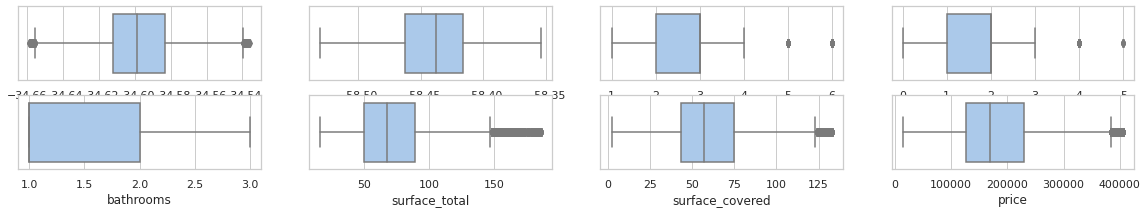

In [ ]:
print('df.shape: ' + str(work_df.shape))
outliers_boxplot(work_df)

Respecto del precio también podemos encontrar outliers al evaluar el valor del metro cuadrado. Primero evaluo el gráfico de cajas.

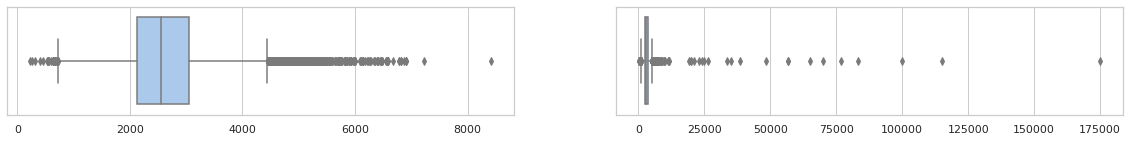

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,2))
sns.boxplot(work_df.price/work_df.surface_total, palette = 'pastel', ax = axs[0])
sns.boxplot(work_df.price/work_df.surface_covered, palette = 'pastel', ax = axs[1])

Se observa que la muestra contiene outliers, especialmente tratándose del precio de la superficie cubierta, por lo que procederé a eliminar los outliers.

In [ ]:
def delete_outliers (df, condition_series):
    riq =  condition_series.quantile(q = 0.75) - condition_series.quantile(q = 0.25)
    condition_aux = ((condition_series > (condition_series.quantile(q = 0.25) - 1.5*riq)) & (condition_series < (condition_series.quantile(q = 0.75) + 1.5*riq)))
    df = df[condition_aux]
    return df

work_df = delete_outliers(work_df, work_df.price/work_df.surface_total)
work_df = delete_outliers(work_df, work_df.price/work_df.surface_covered)

In [ ]:
work_df = delete_outliers(work_df, work_df.price/work_df.rooms)
work_df = delete_outliers(work_df, work_df.price/work_df.bathrooms)

In [ ]:
work_df = delete_outliers(work_df, work_df.price/work_df.bedrooms)

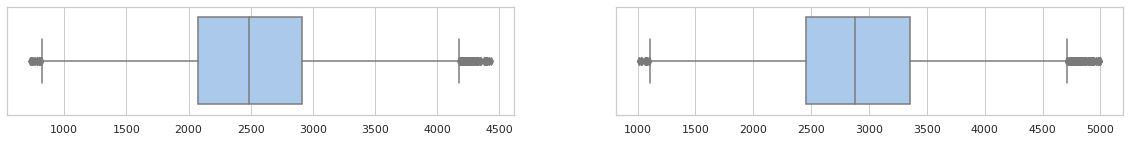

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,2))
sns.boxplot(work_df.price/work_df.surface_total, palette = 'pastel', ax = axs[0])
sns.boxplot(work_df.price/work_df.surface_covered, palette = 'pastel', ax = axs[1])

#### Descarto las columnas que no agregan información (datos únicos, repetidos o texto):
* end_date: este dato no podría ser incluido en nuevas propiedades a evaluar, por lo que carece de sentido incluirlo en un modelo predictor.
* start_date, created_on: en el análisis exploratorio no se observó relación entre la fecha de publicación y el precio en USD (lo que es lógico habiendo pocos años de variación).
* l1 y l2 son redundantes en este punto, debido al filtrado previo.
* currency: es la misma en todo el dataset, categoría única.
* title: para el presente modelizado no será utilizado pero podría agregar valor.
* operation_type: todas son ventas, categoría única.

In [ ]:
work_df = work_df[['l3','rooms','bedrooms','bathrooms','surface_total','surface_covered','price','lat','lon']]

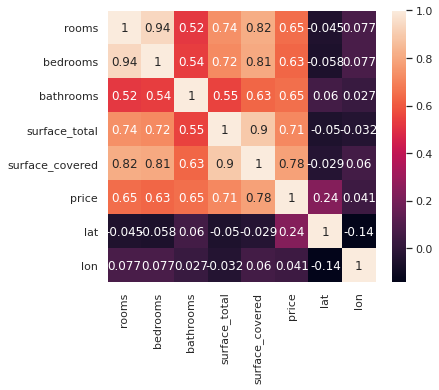

In [ ]:
plt.figure(figsize = (6,5))
corrMatrix = work_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### Asigno valores binarios a la variable categorica l3

In [ ]:
barrios_categoricas = pd.concat([work_df, pd.get_dummies(work_df.l3)], axis=1)

In [ ]:
#print('Cantidad de features previa:',len(name_cols)-1,'\nCantidad de features actual:',len(work_df_2.columns)-1,'\nIncremento:',len(work_df_2.columns)-len(name_cols))

In [ ]:
#work_df_2.head()

#### Creo una variable que rankea a los barrios en función de la mediana de los precios

In [ ]:
work_df_2 = pd.concat([work_df], axis=1)
#work_df_2.columns

In [ ]:
medians = work_df_2.groupby("l3")["price"].median()
medians = medians.sort_values(ascending=False)
medians.head()

l3
Recoleta        238000.0
Barrio Norte    199000.0
Belgrano        198000.0
Las Cañitas     195000.0
Nuñez           190950.0
Name: price, dtype: float64

In [ ]:
medians = medians/medians.max()
medians.head()

l3
Recoleta        1.000000
Barrio Norte    0.836134
Belgrano        0.831933
Las Cañitas     0.819328
Nuñez           0.802311
Name: price, dtype: float64

In [ ]:
work_df_2['neighborhood_P_rank'] = work_df_2['l3'].apply(lambda x: medians[x])
#work_df_2['neighborhood_P_rank*surface_cov'] = work_df_2.neighborhood_P_rank * work_df_2.surface_covered


In [ ]:
price = work_df_2.price
work_df_2.drop(['price'], axis=1, inplace = True)

#### Reducción de dimensionalidad
Aquí hay dos modelos predominantes: SVD y PCA. En este caso utilizaré PCA ya que realiza la reducción por combinación lineal de las variables, aproximando mejor los features en su conjunto; mientras que el SVD realiza la reducción por proximidades y similitudes, promediando subconjuntos puntuales (más útil para la reducción de imágenes).

In [ ]:
from sklearn.decomposition import PCA
N_COMPONENTS = 3

In [ ]:
pca = PCA(n_components=N_COMPONENTS)
X_nuevo = pca.fit_transform(work_df_2[['bedrooms','bathrooms','surface_total','surface_covered','lat','lon','neighborhood_P_rank']])

In [ ]:
columns = []
for i in range(0, N_COMPONENTS):
    columns.append(str(i))

In [ ]:
new = pd.DataFrame(data=X_nuevo,    
                   index=work_df_2.index,   
                   columns=columns)

barrios_8_top = ['Las Cañitas', 'Recoleta', 'Belgrano', 'Barrio Norte', 'Palermo', 'Nuñez', 'Retiro']
barrios_categoricas['barrios_8_top'] = barrios_categoricas['Puerto Madero']
for item in barrios_8_top:
  barrios_categoricas['barrios_8_top'] = barrios_categoricas['barrios_8_top'] + barrios_categoricas[item]

new = pd.concat([new,work_df_2,barrios_categoricas['barrios_8_top']], axis=1)

### Clusterización por latitud y longitud, ya que las concentraciones de oferta puede agregar información sobre el negocio inmobiliario de cada clúster.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
clustering = MiniBatchKMeans(random_state=1950)
agg_model = clustering.fit(new[['lat','lon']].to_numpy())
agg_model

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=1950,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [ ]:
new['cluster'] = agg_model.fit_predict(new[['lat','lon']].to_numpy())
#new = pd.concat([new, pd.get_dummies(new.cluster)], axis=1)

In [ ]:
new.shape

(38348, 13)

In [ ]:
new.drop(['lat','lon','l3'], axis=1, inplace = True) #'cluster'
new.head(3)

,0,1,2,rooms,bedrooms,bathrooms,surface_total,surface_covered,neighborhood_P_rank,barrios_8_top
1,-4.065000,1.029882,-0.455920,2.0,1.0,2.0,70.0,58.0,0.537815,0
8,-36.663496,2.911566,-0.114247,1.0,1.0,1.0,45.0,37.0,0.525210,0
9,-36.663496,2.911566,-0.114247,1.0,1.0,1.0,45.0,37.0,0.525210,0


In [ ]:
#plt.figure(figsize = (20,8))
#corrMatrix = new.corr()
#sns.heatmap(corrMatrix, annot=True)
#plt.show()

Se observan menos correlaciones fuertes que en la matriz anterior, no obstante esto no implica que el error del modelo aumente ya que estamos agregando información de las variables categóricas que podría permitir que los modelos aumenten su precisión al detectar condiciones al ajuste de los precios.

Antes de iniciar el modelado, aplicaré una transformación al precio para que tenga una distribución más aproximada a la gaussiana.

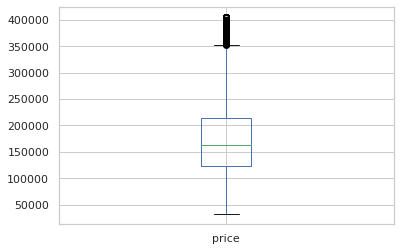

In [ ]:
price.plot.box()

In [ ]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

In [ ]:
test_price = price.copy()

In [ ]:
test_price = test_price.to_numpy().reshape(-1, 1)
pt.fit(test_price)
test_price = pt.transform(test_price)

In [ ]:
test_price = pd.Series(test_price.ravel(), index = work_df_2.index)

In [ ]:
price = test_price.copy()

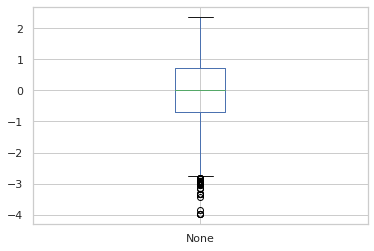

In [ ]:
price.plot.box()

In [ ]:
#new.rename(columns={0: 'a', 1: 'b', 2:'c', 3:'d', 4: 'e', 5: 'f', 6:'g', 7:'h'}, inplace=True)

In [ ]:
new.columns

Index(['0', '1', '2', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'neighborhood_P_rank', 'barrios_8_top'],
      dtype='object')

## Modelado

In [ ]:
columns = ['name','best_model','rmse_train','rmse_test','d_std_train','d_std_test']
models_df = pd.DataFrame(columns=columns)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error

cv = 3

def data_inverse_transform (y_train, X_train, model, pt):
  y_pred_train = pt.inverse_transform(model.predict(X_train).reshape(-1, 1))
  y_train_real = pt.inverse_transform(y_train.to_numpy().reshape(-1, 1))

  return y_train_real, y_pred_train

def model_train_mse (name, model, params, cv, pt, X_train, X_test, y_train, y_test):
  gridsearch = GridSearchCV(model, param_grid = params, cv = cv)
  gridsearch.fit(X_train,y_train)

  best_model = gridsearch.best_estimator_

  y_train_real, y_pred_train = data_inverse_transform(y_train, X_train, best_model, pt)
  y_test_real, y_pred_test = data_inverse_transform(y_test, X_test, best_model, pt)

  rmse_train = np.sqrt(mean_squared_error(y_train_real, y_pred_train)), 
  rmse_test = np.sqrt(mean_squared_error(y_test_real, y_pred_test)), 
  d_std_train = np.sqrt(np.square(np.subtract(y_train_real,y_pred_train)).std()), 
  d_std_test = np.sqrt(np.square(np.subtract(y_test_real,y_pred_test)).std())

  dict_model = {
      'name': name, 
      'best_model': best_model, 
      'rmse_train': rmse_train, 
      'rmse_test': rmse_test, 
      'd_std_train': d_std_train, 
      'd_std_test': d_std_test
  }
  return dict_model

def model_plot_pred_vs_test (X_test, y_test, pt, best_model):
  data_grafico = pd.DataFrame()

  y_test_real, y_pred_test = data_inverse_transform(y_test, X_test, best_model, pt)

  data_grafico['y_test'] = pd.Series(y_test_real.ravel()).values
  data_grafico['pred'] = y_pred_test

  data_grafico = data_grafico.sort_values(by=['y_test'], ascending=True)
  data_grafico['X'] = range(0, data_grafico.shape[0])

  plt.figure(figsize = (15,5))
  sns.set_theme(style="whitegrid")
  sns.scatterplot(x = data_grafico.X, y = data_grafico.pred, color="r", linewidth=1, label="y_pred")
  sns.lineplot(x = data_grafico.X, y = data_grafico.y_test, palette="tab10", linewidth=2.5, label="y_test")

  plt.show()
  return

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new.iloc[:,:],price, test_size=0.2, random_state=1905)
testigo = y_test.copy()

# Linear Regression

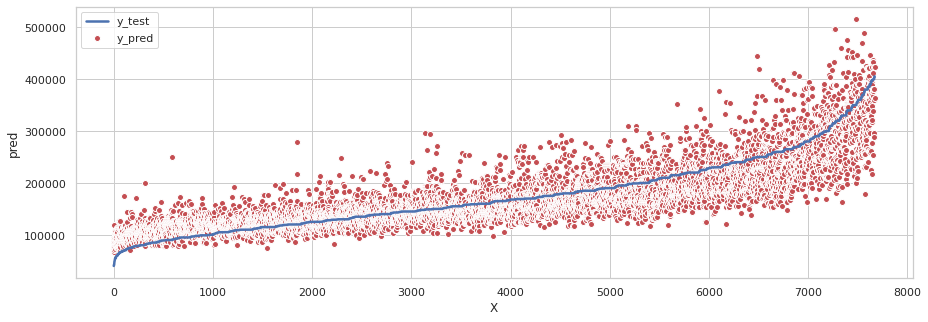

In [ ]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

model_plot_pred_vs_test (X_test, y_test, pt, best_model)

### Decision Tree Regressor

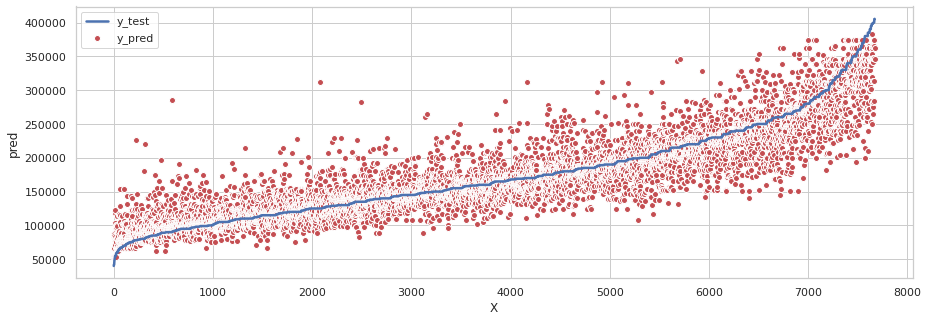

In [ ]:
# parámetros para los árboles
params = {"max_depth":[30,35],
                                 "criterion":['mse'],
                                 "splitter":['best'],
                                 "random_state": [1950],
                                 "min_samples_split":[0.0001,0.00001],
                                 "min_samples_leaf":[0.001,0.0001]}

model = DecisionTreeRegressor()
name = 'tree'

dict_model = model_train_mse (name, model, params, cv, pt, X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())
models_df = models_df.append(dict_model, ignore_index=True)

model_plot_pred_vs_test (X_test, y_test, pt, best_model = dict_model['best_model'])

#dict_model.clear()

# Random Forest

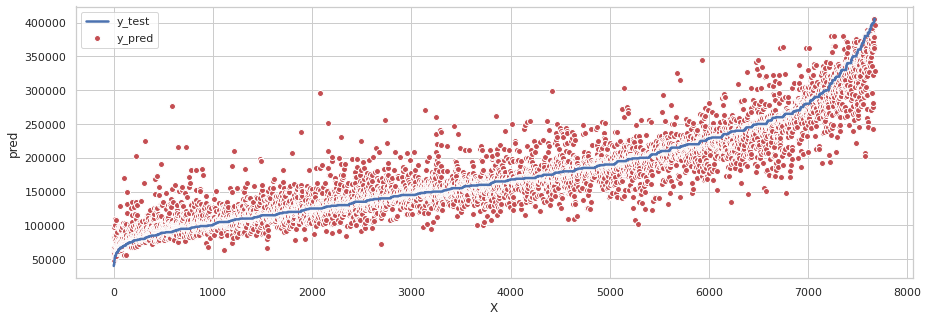

In [ ]:
params = {
    'n_estimators' : [140], #default 100
    'criterion' : ['mse'], # mse
    'max_depth' : [35], # None
    'min_samples_split' : [0.00001], # 2
    'min_samples_leaf' : [0.00001], # 1
    'min_weight_fraction_leaf' : [0.0] # 0.0
}

model = RandomForestRegressor()
name = 'random forest'

#y_train_rtree = y_train.values.reshape(len(y_train)).copy()

dict_model = model_train_mse(name, model, params, cv, pt, X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())

models_df = models_df.append(dict_model, ignore_index=True)

model_plot_pred_vs_test (X_test, y_test, pt, best_model = dict_model['best_model'])

In [ ]:
models_df.head()

,name,best_model,rmse_train,rmse_test,d_std_train,d_std_test
0,tree,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...","(26676.59215363758,)","(29513.94003652387,)","(40271.517946104555,)",45505.811953
1,random forest,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...","(9383.169221517392,)","(22615.72780000339,)","(16389.953799793442,)",39931.850337


# SVR

[LibSVM][LibSVM][LibSVM][LibSVM]

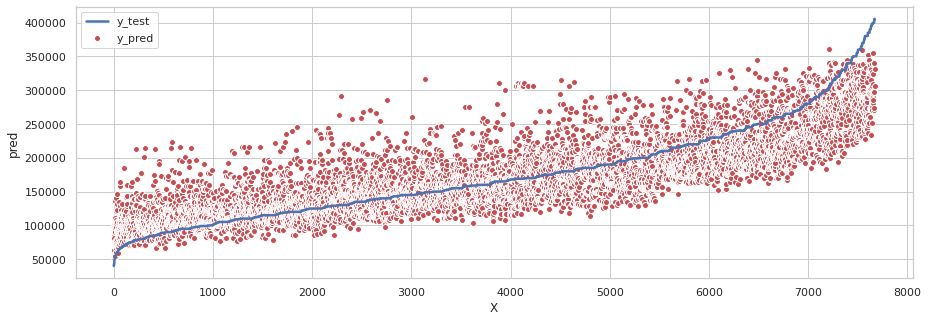

In [ ]:
params = {
    #'kernel' : ['linear']#,'poly', 'rbf'], 
    #'degree' : [3,4,5], 
    #'C' : [20,30],
    'verbose': [True],
}
model = SVR()
name = 'svr'

dict_model = model_train_mse(name, model, params, cv, pt, X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())

models_df = models_df.append(dict_model, ignore_index=True)

model_plot_pred_vs_test (X_test, y_test, pt, best_model = dict_model['best_model'])

dict_model.clear()

In [ ]:
models_df.head()

,name,best_model,rmse_train,rmse_test,d_std_train,d_std_test
0,tree,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...","(15999.25658119354,)","(27892.566784310002,)","(28242.308587701576,)",47184.427897
1,random forest,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...","(9354.129418802147,)","(22375.848382230968,)","(16177.94655569377,)",39439.769186
2,svr,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","(38434.08622109574,)","(39003.93083795271,)","(51590.87457802618,)",52407.104746


# XGBoost

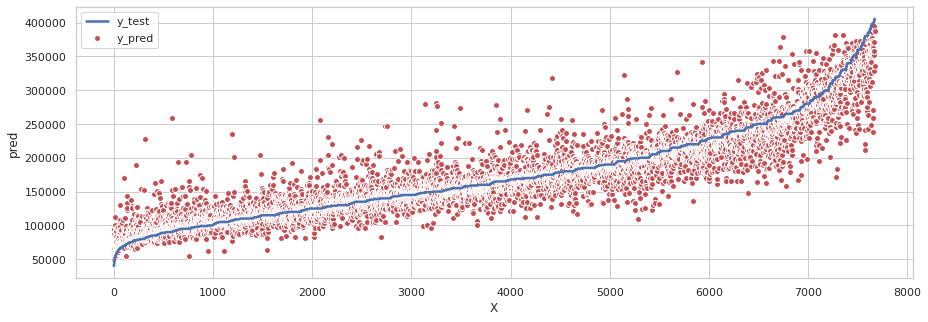

In [ ]:
params = {
    'n_estimators':[210],#,20,30,40,50], 
    'reg_lambda':[0.28], 
    'gamma':[0.07],
    'max_depth':[10],
    'random_state':[1950],
    'verbosity':[0],
}

model = xgb.XGBRegressor()
name = 'xgb'

dict_model = model_train_mse(name, model, params, cv, pt, X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())

models_df = models_df.append(dict_model, ignore_index=True)

model_plot_pred_vs_test (X_test, y_test, pt, best_model = dict_model['best_model'])

In [ ]:
models_df.head()

,name,best_model,rmse_train,rmse_test,d_std_train,d_std_test
0,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...","(14340.337030526804,)","(23870.490416324214,)","(22409.265975174272,)",40243.346965


# KNN Regressor

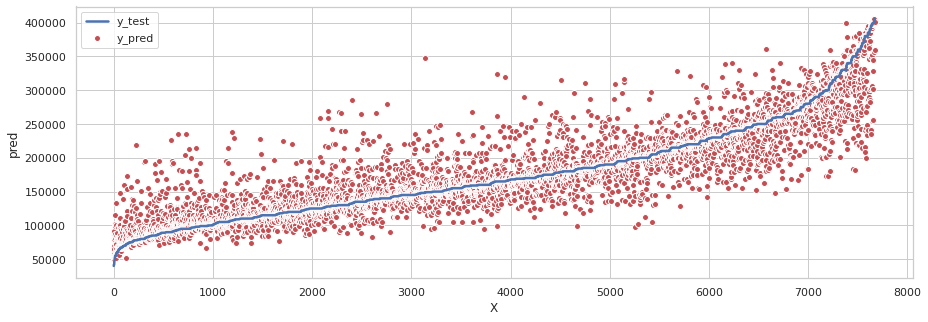

In [ ]:
params = {
    'n_neighbors':[9,20,30,50], 
    'p':[1],#,2], 
    'algorithm':['brute'],#['auto','ball_tree','kd_tree','brute'],
    'weights':['distance'],#['uniform','distance'],
}
model = KNeighborsRegressor()
name = 'knn_reg'

dict_model = model_train_mse(name, model, params, cv, pt, X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())

models_df = models_df.append(dict_model, ignore_index=True)

model_plot_pred_vs_test (X_test, y_test, pt, best_model = dict_model['best_model'])

In [ ]:
models_df.head()

,name,best_model,rmse_train,rmse_test,d_std_train,d_std_test
0,tree,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...","(15999.25658119354,)","(27892.566784310002,)","(28242.308587701576,)",47184.427897
1,random forest,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...","(9354.129418802147,)","(22375.848382230968,)","(16177.94655569377,)",39439.769186
2,svr,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","(38434.08622109574,)","(39003.93083795271,)","(51590.87457802618,)",52407.104746
3,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...","(14804.460958149737,)","(23470.928084549596,)","(23542.840433022582,)",39827.548826
4,knn_reg,"KNeighborsRegressor(algorithm='brute', leaf_si...","(4375.542110826285,)","(26420.51251617748,)","(10485.949693603061,)",47603.197031


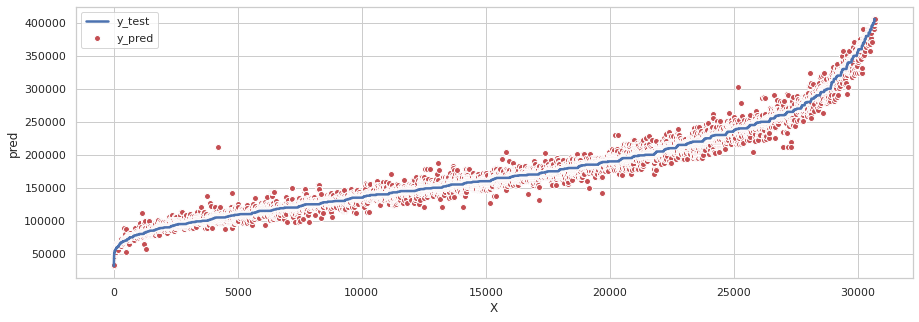

In [ ]:
model_plot_pred_vs_test (X_test = X_train, y_test = y_train, pt=pt, best_model = dict_model['best_model'])

In [ ]:
rmse_train = []
rmse_test = []
depth = []

for i in range(1, 35):
    depth.append(i)
    regresor_dt_ingenuo = DecisionTreeRegressor(max_depth = i, random_state = 1905)
    regresor_dt_ingenuo.fit(X=X_train,y=y_train)
    
    # Predecimos sobre nuestro set de entrenamieto
    y_pred = regresor_dt_ingenuo.predict(X_train)
    # Comaparamos con las etiquetas reales
    rmse_train.append((mean_squared_error(y_train,y_pred)))
    
    # Predecimos sobre nuestro set de entrenamieto
    y_pred = regresor_dt_ingenuo.predict(X_test)
    # Comaparamos con las etiquetas reales
    rmse_test.append((mean_squared_error(y_test,y_pred)))

In [ ]:
plt.figure(figsize = (10,5))
sns.set_theme(style="whitegrid")
sns.lineplot(x = depth, y = rmse_train, palette="tab10", linewidth=2.5, label="train", marker="o")
sns.lineplot(x = depth, y = rmse_test, palette="tab10", linewidth=2.5, label="test", marker="o")

In [ ]:
regresor_dt_ingenuo = DecisionTreeRegressor(max_depth=15, random_state = 1950)
regresor_dt_ingenuo.fit(X=X_train,y=y_train)

# Predecimos sobre nuestro set de testeo
y_pred = regresor_dt_ingenuo.predict(X_test)
# Comaparamos con las etiquetas reales
print('MSE:  ' + str(round(mean_squared_error(y_pred,y_test),2)) +'\nRMSE: ' + str(round(np.sqrt(mean_squared_error(y_pred,y_test)),2)))

In [ ]:
regresor_dt_ingenuo.feature_importances_

## Opcion 2

In [ ]:
# Asigno valores binarios a la variable categorica l3
work_df_3 = work_df
price = work_df_3.price
work_df_3.drop(['l3','price'], axis=1, inplace = True)
work_df_3.columns

In [ ]:
N = 3

pca = PCA(n_components=N)
X_nuevo_2 = pca.fit_transform(work_df_3)

columns = []
for i in range(0, N):
    columns.append(str(i))
    
new_3 = pd.DataFrame(data=X_nuevo_2,    # values
              index=work_df_3.index,    # 1st column as index
              columns=columns)

X_train, X_test, y_train, y_test = train_test_split(new_3.iloc[:,:],price, test_size=0.2, random_state=1905)

rmse_train = []
rmse_test = []
depth = []

for i in range(1, 35):
    depth.append(i)
    regresor_dt_ingenuo = DecisionTreeRegressor(max_depth = i, random_state = 1905)
    regresor_dt_ingenuo.fit(X=X_train,y=y_train)
    
    # Predecimos sobre nuestro set de entrenamieto
    y_pred = regresor_dt_ingenuo.predict(X_train)
    # Comaparamos con las etiquetas reales
    rmse_train.append((mean_squared_error(y_train,y_pred)))
    
    # Predecimos sobre nuestro set de entrenamieto
    y_pred = regresor_dt_ingenuo.predict(X_test)
    # Comaparamos con las etiquetas reales
    rmse_test.append((mean_squared_error(y_test,y_pred)))

In [ ]:
plt.figure(figsize = (10,5))
sns.set_theme(style="whitegrid")
sns.lineplot(x = depth, y = rmse_train, palette="tab10", linewidth=2.5, label="train", marker="o")
sns.lineplot(x = depth, y = rmse_test, palette="tab10", linewidth=2.5, label="test", marker="o")

In [ ]:
regresor_dt_ingenuo = DecisionTreeRegressor(max_depth=15, random_state = 1950)
regresor_dt_ingenuo.fit(X=X_train,y=y_train)

# Predecimos sobre nuestro set de testeo
y_pred = regresor_dt_ingenuo.predict(X_test)
# Comaparamos con las etiquetas reales
print('MSE:  ' + str(round(mean_squared_error(y_pred,y_test),2)) +'\nRMSE: ' + str(round(np.sqrt(mean_squared_error(y_pred,y_test)),2)))

In [ ]:
parametros_random_forest_regressor = {
    'n_estimators' : [100, 120, 140, 160], #default 100
    'criterion' : ['mse', 'mae'], # mse
    'max_depth' : [3, 6, 9, 12, 15, None], # None
    'min_samples_split' : [2, 4, 6, 8], # 2
    'min_samples_leaf' : [1, 3, 5, 7], # 1
    'min_weight_fraction_leaf' : [0.0, 0.5, 1.0, 1.5] # 0.0
}

In [ ]:
parametros_svm_regressor = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], # default=’rbf’
    'degree' : [3, 6, 9, 12], # default=3
    'gamma' : ['scale', 'auto'], # or float, default=’scale’
    'coef0' : [0.0. 0.5, 1.0, 1.5], #float, default=0.0
}

In [ ]:
i = [1,2,3,4,5,6]
j = [1,2]
k = [1,2,3,4]
total = 0
for iiem in i:
    for jitem in j:
        for kitem in k:
            total += 1
total

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
def ba_stocks_pca(df):
    n_columns = len(df.columns)
    dictionary = {
        'n_components' : list(range(int(n_columns * 0.25), int(n_columns * 0.8), int(n_columns * 0.1))),
        'whiten' : [False,True],
        'svd_solver' : ['auto','full','arpack','randomized']
    }
    pca = PCA()
    compressed_df = GridSearchCV(pca, dictionary, cv = 3)
    return compressed_df.fit(df)
    